In [3]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score



# Load data

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
type(mnist)

In [ ]:
# function to sort data 
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [ ]:
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [ ]:
mnist["data"], mnist["target"]

In [ ]:
mnist.data.shape

## Assign data 

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

In [ ]:
y.shape

## Peak into a row of data

In [2]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
some_digit = X[36000]

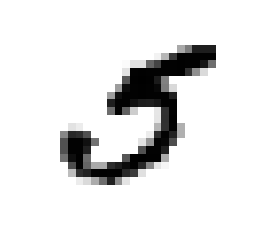

In [12]:
plot_digit(some_digit)

## Visualize data 

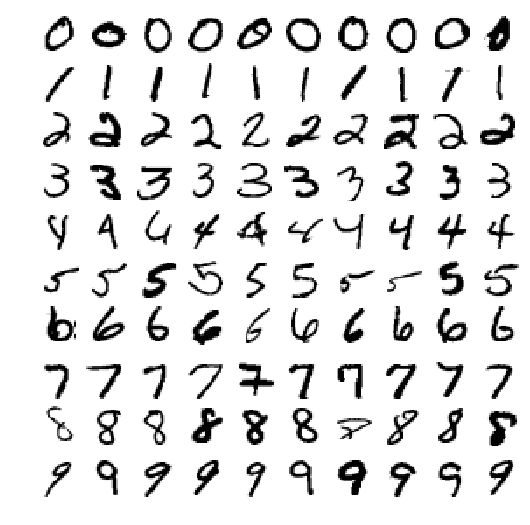

In [51]:
# EXTRA, combine into single array. Another option would be to facet plot 
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

## Save data 

In [ ]:
joblib.dump(mnist, 'data/raw/'+'mnist'+'.pkl')

## Load saved data

In [4]:
mnist = joblib.load('data/raw/'+'mnist'+'.pkl')
X, y = mnist["data"], mnist["target"]

# Split data into training sets 

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Shuffle data
This helps to properly train the model so that it doesn't see the same data in a row 

In [6]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Train a Binary Classiffier 

In [7]:
# selects all labels equal to 5 to True, otherwise False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
y_test_5

array([False, False, False, ..., False, False, False])

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

## Make prediction 

In [10]:
# test on previous sample 
some_digit = X[36000]
sgd_clf.predict([some_digit])

array([ True])

# Measure Binary Classifier Performance 
Using accuracy doesn't work for a classifier, because even a dummy classifier could guess correctly 90% of the time

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

## Confusion Matrix 
much better for judging classifier 

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [14]:
# a perfect matrix would have all zeros along the diagonal
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision, accuracy of positive predictions 
precision = $\frac{TP}{TP+FP}$

In [15]:
precision_score(y_train_5, y_train_pred)

0.7687135020350381

## Recall (sensitivity or true positive rate) ratio of positive instances correctly detected by classifier  
recall = $\frac{TP}{TP+FN}$

In [16]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

## $F_1$ score, the harmonic mean of precision and recall 

In [17]:
f1_score(y_train_5, y_train_pred)

0.7846820809248555

## Precision/Recall tradeoff 

In [18]:
# return scores for all instances in in training set 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [19]:
y_scores.shape

(60000,)

In [20]:
y_scores.ndim

1

In [21]:
# plot precision recall curve 
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

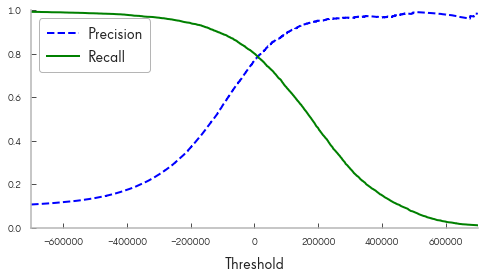

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

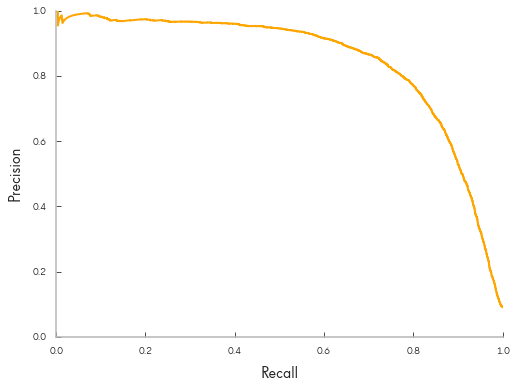

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "orange", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## ROC curves
- Want area under curve to be near unity
- Use the PR curve when positive class is rare or when you care more about false positives than false negatives, ROC curve otherwise. Few positives will make the ROC curve look good. 

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

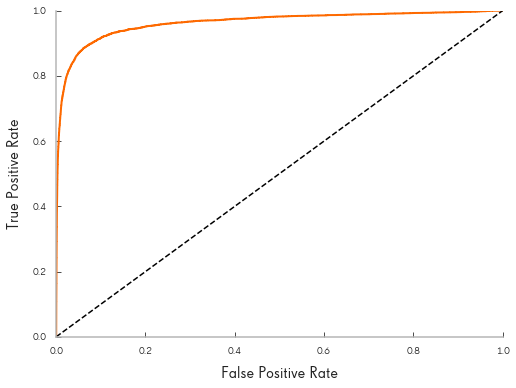

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

## Let's try Random Forrest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
# instantiate model 
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
# train model, return predict_proba as scores 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [28]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

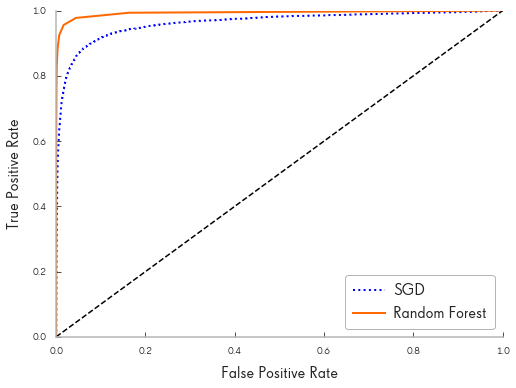

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [31]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [32]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# Multiclass classification

In [33]:
# sklearn auto handles multiclasses with most classifiers
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [34]:
# this yiels the score of each classifier 
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [37]:
# Forests also handles multiclass classification 
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [38]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

## With cross validation 

In [39]:
# SGD
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

## Scaling the data improves model scores 

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.94056189, 0.93909695, 0.93914087])

# Error Analysis 
Once you find a model that works, you want to analyze the error it makes. 
- in the confusion matrtix below we see that 8 and 9 are commonly misclassified 
- 3's and 5's are commonly confused

In [42]:
# first look at the confusion matrix 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [43]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

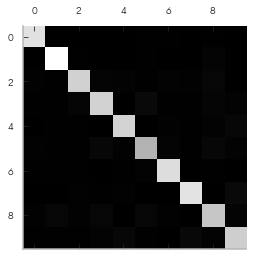

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

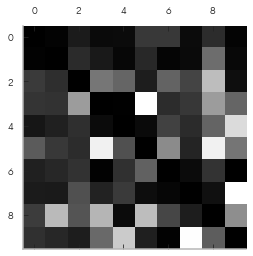

In [48]:
# replace diag values with zereos
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

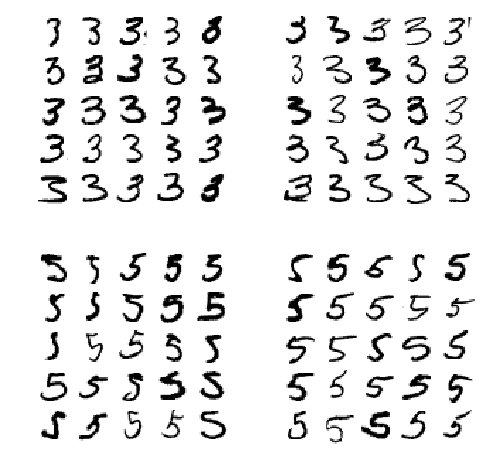

In [52]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Try KNN classifier

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [54]:
y_knn_pred = knn_clf.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [57]:
# first look at the confusion matrix 
conf_mx = confusion_matrix(y_test,y_knn_pred)
conf_mx

array([[ 973,    1,    1,    0,    0,    1,    3,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    1,    0,    0,    0],
       [  10,    5,  995,    2,    1,    0,    0,   16,    3,    0],
       [   0,    1,    3,  974,    1,   14,    1,    7,    4,    5],
       [   1,    5,    0,    0,  950,    0,    4,    3,    0,   19],
       [   4,    0,    0,    9,    2,  862,    7,    1,    3,    4],
       [   4,    2,    0,    0,    3,    3,  946,    0,    0,    0],
       [   0,   17,    4,    0,    3,    0,    0,  994,    0,   10],
       [   5,    2,    4,   14,    5,   11,    4,    4,  920,    5],
       [   3,    4,    2,    7,    9,    4,    1,   10,    1,  968]])